In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("ACME-HappinessSurvey2020.csv")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


# Random Forest Classifier test


In [31]:
from sklearn.ensemble import RandomForestClassifier

#np.random.seed(42)

X = df.drop('Y', axis=1)
y= df['Y']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

# Initialize the classifier
clf = RandomForestClassifier(10000)
# Fit the classifier
clf.fit(X_train, y_train)

# Test the accuracy of the classifier model
clf.score(X_test,y_test)    

0.6538461538461539

# Gradient Boost


In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier(random_state=42)

# Fit the model
clf_gb.fit(X_train_scaled, y_train)

# Predict and calculate accuracy
y_pred_gb = clf_gb.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
accuracy_gb


0.6153846153846154

# Support Vector Machine (SVM)

In [41]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Support Vector Classifier
clf_svc = SVC(kernel='rbf', C=1, random_state=42)

# Fit the model
clf_svc.fit(X_train_scaled, y_train)

# Predict and calculate accuracy
y_pred_svc = clf_svc.predict(X_test_scaled)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc * 100:.2f}%")


SVM Accuracy: 50.00%


# XG Boost

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize XGBoost Classifier
clf_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
clf_xgb.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred_xgb = clf_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")


XGBoost Accuracy: 65.38%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Logistic Regression with Cross-Validation


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Initialize Logistic Regression
clf_lr = LogisticRegression(max_iter=1000, random_state=42)

# Perform cross-validation and evaluate accuracy
cv_scores = cross_val_score(clf_lr, X_train_scaled, y_train, cv=5)

# Fit and evaluate accuracy on the test set
clf_lr.fit(X_train_scaled, y_train)
y_pred_lr = clf_lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Test Accuracy: {accuracy_lr * 100:.2f}%")


Logistic Regression Cross-Validation Accuracy: 62.00%
Test Accuracy: 46.15%


# Increasing accuracy for best performing algorithm XGBoost


In [48]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier
clf_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Loop to train the model until accuracy > 73%
max_accuracy = 0
best_params = None
best_model = None

# Set a limit on the number of iterations
n_iterations = 1000
for iteration in range(n_iterations):
    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=clf_xgb,
        param_distributions=param_grid,
        n_iter=10,  # number of different combinations to try per iteration
        cv=5,  # 5-fold cross-validation
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the randomized search
    random_search.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = random_search.best_estimator_.predict(X_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Update max_accuracy and save the best model if better accuracy is found
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
    
    print(f"Iteration {iteration+1}: Accuracy = {accuracy * 100:.2f}%")
    
    # Stop if accuracy is greater than 73%
    if accuracy > 0.73:
        print(f"Target reached! Best Accuracy = {accuracy * 100:.2f}%")
        break

# If the loop completes without reaching the target, print the best accuracy achieved
if max_accuracy < 0.73:
    print(f"Max accuracy achieved: {max_accuracy * 100:.2f}%")

# Best hyperparameters
print(f"Best Hyperparameters: {best_params}")


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 1: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 2: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 3: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 4: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 5: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 6: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 7: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 8: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 9: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 10: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 11: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 12: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 13: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 14: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 15: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 16: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 17: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 18: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 19: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 20: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 21: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 22: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 23: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 24: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 25: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 26: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 27: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 28: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 29: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 30: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 31: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 32: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 33: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 34: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 35: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 36: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 37: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 38: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 39: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 40: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 41: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 42: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 43: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 44: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 45: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 46: Accuracy = 46.15%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration 47: Accuracy = 46.15%


KeyboardInterrupt: 


# Updating feature importance


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

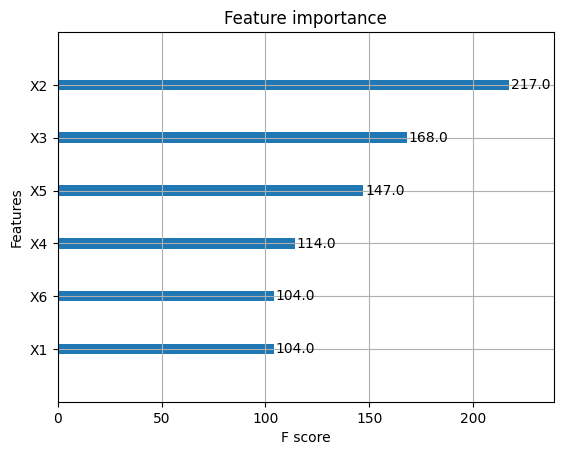

Accuracy with Important Features: 65.38%


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [55]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Initialize the XGBoost Classifier
clf_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model on scaled data
clf_xgb.fit(X_train, y_train)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plot_importance(clf_xgb, importance_type="weight")
plt.show()

# Get feature importances
importances = clf_xgb.feature_importances_

# Filter out less important features by threshold
important_features = X_train.columns[importances > 0.05]

# Keep only important features
X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]

# Fit the model again with selected important features
clf_xgb_imp = XGBClassifier(random_state=82, use_label_encoder=False, eval_metric='mlogloss')
clf_xgb_imp.fit(X_train_imp, y_train)

# Predict and calculate accuracy
y_pred_imp = clf_xgb_imp.predict(X_test_imp)
accuracy_imp = accuracy_score(y_test, y_pred_imp)
print(f"Accuracy with Important Features: {accuracy_imp * 100:.2f}%")


# Third test:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('ACME-HappinessSurvey2020.csv')

# Step 1: Data Preprocessing
X = df.drop(columns=['Y'])
y = df['Y']

# Normalize/Standardize the features

# Step 2: Hyperparameter Tuning using GridSearchCV
# Define the models
rf_model = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
}

# GridSearchCV for Random Forest
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X, y)


# Best parameters found from GridSearchCV
print("Best parameters for Random Forest:", grid_rf.best_params_)

# Step 4: Training and Evaluation
# np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Accuracy of each individual model
rf_accuracy = accuracy_score(y_test, grid_rf.best_estimator_.predict(X_test))

# Print the accuracies
print("Random Forest Accuracy:", rf_accuracy)

Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 50}
Random Forest Accuracy: 0.9615384615384616
